### Import
Import all the necessary packages

In [1]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geopandas as gdp
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

### Data import

Read and import all the competition dataframes

In [2]:
df_airlines = pd.read_csv('Data/airlines.csv')
df_airports = pd.read_csv('Data/airports.csv')
df_flights = pd.read_csv('Data/flights_train.csv')
df_flights_test = pd.read_csv('Data/flights_test.csv')

In [3]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [27]:
def change_time(gg):
    time = "0000"[len(str(gg))-1:-1] + str(gg)
    return time

In [31]:
test = df_flights.loc[:100, 'SCHEDULED_DEPARTURE':'DEPARTURE_TIME']
test['DEPARTURE_DELAY'] = test['DEPARTURE_TIME'] - test['SCHEDULED_DEPARTURE']

test['SCHEDULED_DEPARTURE'] = test['SCHEDULED_DEPARTURE'].apply(lambda row: change_time(row))
test['DEPARTURE_TIME'] = test['DEPARTURE_TIME'].apply(lambda row: change_time(int(row)))
test

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY
0,0005,2354,2349.0
1,0010,0002,-8.0
2,0020,0018,-2.0
3,0020,0015,-5.0
4,0025,0024,-1.0
...,...,...,...
96,0535,0530,-5.0
97,0538,0634,96.0
98,0538,0535,-3.0
99,0540,0536,-4.0


In [6]:
subset = df_flights.loc[1000:1010, 'SCHEDULED_DEPARTURE':'ARRIVAL_DELAY']
#subset['sch'] = subset['SCHEDULED_DEPARTURE'] + subset['SCHEDULED_TIME']
#subset['sch_diff'] = subset['SCHEDULED_ARRIVAL'] - subset['sch']
subset['ARRIVAL_TIME'] = subset['SCHEDULED_ARRIVAL'] + subset['ARRIVAL_DELAY']
subset['sth'] = subset['SCHEDULED_DEPARTURE'] + subset['SCHEDULED_TIME']
subset

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ARRIVAL_TIME,sth
1000,715,709.0,10.0,719.0,225.0,1371,900,-23.0,877.0,940.0
1001,715,711.0,8.0,719.0,150.0,937,945,-23.0,922.0,865.0
1002,715,712.0,18.0,730.0,205.0,1587,1240,-8.0,1232.0,920.0
1003,715,708.0,9.0,717.0,133.0,622,828,-3.0,825.0,848.0
1004,715,712.0,12.0,724.0,170.0,1023,1005,-1.0,1004.0,885.0
1005,715,719.0,13.0,732.0,199.0,1121,934,-3.0,931.0,914.0
1006,715,747.0,14.0,801.0,375.0,2585,1030,21.0,1051.0,1090.0
1007,715,710.0,19.0,729.0,315.0,2422,1530,-19.0,1511.0,1030.0
1008,715,719.0,12.0,731.0,105.0,551,1000,-5.0,995.0,820.0
1009,715,713.0,16.0,729.0,175.0,1096,1010,-1.0,1009.0,890.0


### Flights dataframe information
There are no null values


| Column                  | Units     | Description                                       |
|:------------------------|:----------|:--------------------------------------------------|
| **SCHEDULED_DEPARTURE** | [Time]    | Scheduled departure time                          |
| **DEPARTURE_TIME**      | [Time]    | Real departure time                               |
| **TAXI_OUT**            | [minutes] | Taxi minutes around the airport (to runaway)      |
| **WHEELS_OFF**          | [Time]    | Real take-off time -> (DEPARTURE_TIME + TAXI_OUT) |
| **SCHEDULED_TIME**      | [Minutes] | Scheduled flight minutes                          |
| **SCHEDULED_ARRIVAL**   | [Time]    | Scheduled arrival time -> (                       |


# Plots

In [7]:
# Add the number of flights per airport
count_flights = df_flights['ORIGIN_AIRPORT'].value_counts()
count_flights = count_flights.to_frame().rename(columns={"ORIGIN_AIRPORT": "Count Flights"})
count_flights['IATA_CODE'] = count_flights.index
df_airports = pd.merge(df_airports, count_flights)

In [8]:
# define properties of markers and labels
colors = ['blue', 'lightblue', 'yellow', 'orange', 'red']
size_limits = [1, 100, 1000, 10000, 100000]
labels = ['< {}'.format(size_limits[0])]
for i in range(1, len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
labels.append("> {}".format(size_limits[-1]))

df_airports_plot = df_airports.set_index('IATA_CODE')
lab_dict, col_dict = {}, {}
for index, (code, count) in df_airports[['IATA_CODE', 'Count Flights']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights.loc[code]['Count Flights']]
    ind = isize[-1]
    lab_dict[code] = labels[ind]
    col_dict[code] = colors[ind]
df_airports_plot['label'] = pd.Series(lab_dict)
df_airports_plot['color'] = pd.Series(col_dict)
    

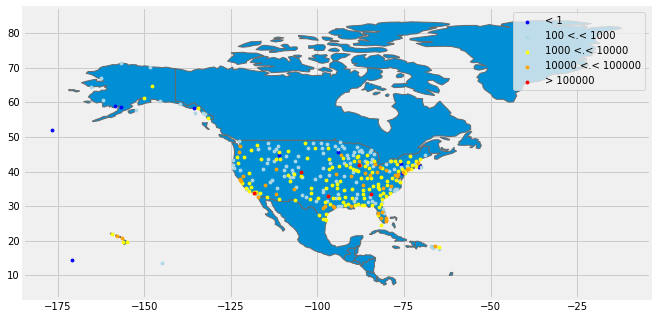

In [13]:
# Add geometry data of airports location:
gdf_airports = gdp.GeoDataFrame(
    df_airports_plot, geometry=gdp.points_from_xy(df_airports.LONGITUDE, df_airports.LATITUDE))
gdf_airports

# We restrict to USA. ->> maybe we could also plot the states
world_df = gdp.read_file(gdp.datasets.get_path("naturalearth_lowres"))
ax = world_df[world_df.continent == 'North America' ].plot()
# ax = world_df[world_df.name == 'United States of America' ].plot()
              
# We can now plot our ``GeoDataFrame``.
for i, col in enumerate(colors):
    gdf_airports[gdf_airports['color'] == col].plot(ax=ax, color=col, markersize=8, label = labels[i])
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = [10,7]
